In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import pandas as pd

In [2]:
dataset = "sklearn"

In [3]:
if "sklearn" in dataset:
    breast_cancer = load_breast_cancer()
    df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
    df["benign"] = breast_cancer.target
else:
    df = pd.read_csv('breast_cancer.csv', delimiter=',' , header=0,encoding='latin-1').dropna()
    X = df.loc[:, df.columns != "Class"]
    original_df = X.copy()
    y = df.loc[:, df.columns == "Class"]
    y = binary_labels = y.map(lambda x: 1 if x == 'recurrence-events' else 0)

In [4]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,benign
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [35]:
if "sklearn" in dataset:
    """majority_df = df[df["benign"] == 1]
    minority_df = df[df["benign"] == 0]
    minority_downsampled_df = resample(minority_df, replace=True, n_samples=30, random_state=42)
    downsampled_df = pd.concat([majority_df, minority_downsampled_df])
    downsampled_df["benign"].value_counts()"""
    y = df["benign"]
    X = df.drop("benign", axis=1)
    original_df = X.copy()
else:
    # Encode categorical variables
    le = LabelEncoder()
    df = df.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)


## PCA Plot Generation

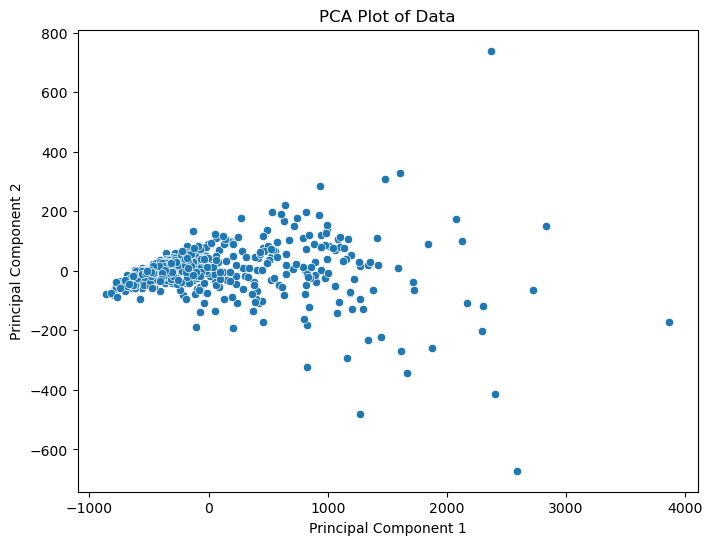

In [6]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)

components = pca.fit_transform(df)

# Create a DataFrame with the reduced dimensions
components_df = pd.DataFrame(data=components, columns=['Component 1', 'Component 2'])

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Component 1', y='Component 2', data=components_df)
plt.title('PCA Plot of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Local Outlier Factor Technique
We use the LocalOutlierFactor technique to find outliers

In [7]:
from sklearn.neighbors import LocalOutlierFactor 
import numpy as np

lof = LocalOutlierFactor(n_neighbors=15) 
lof.fit(df)

# Calculate the outlier scores for each point 
lof_scores = lof.negative_outlier_factor_ 

# Identify the points with the highest outlier scores 
lof_outliers = np.argwhere(lof_scores > np.percentile(lof_scores, 85)) 


In [8]:
# Plot anomly 
def plot_anomaly(outliers, method_name):
    colors=['green','red'] 

    for i in range(components_df.shape[0]): 
        if i not in outliers: 
            plt.scatter(components_df.iloc[i,0], components_df.iloc[i,1], color=colors[0]) # Not anomaly 
    for i in outliers: 
        plt.scatter(components_df.iloc[i,0], components_df.iloc[i,1], color=colors[1]) # anomaly 
    plt.xlabel('Principal Component 1',fontsize=13) 
    plt.ylabel('Principal Component 2',fontsize=13)         
    plt.title('Anomaly by ' + method_name,fontsize=16)         
    plt.show() 

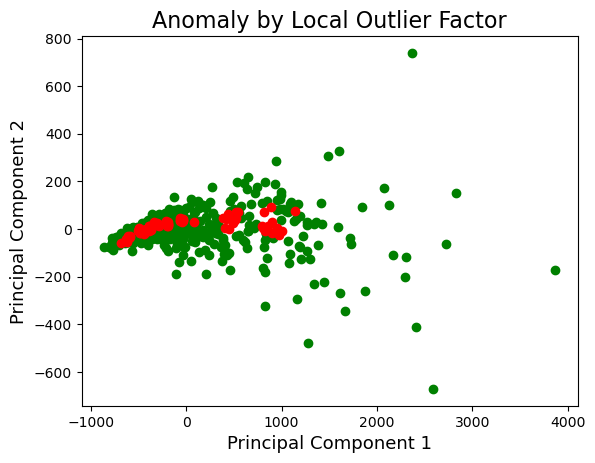

In [9]:
plot_anomaly(lof_outliers, "Local Outlier Factor")

## Isolation Forest Technique
We test and compare with the Isolation Forest technique the outliers found

In [10]:
from sklearn.ensemble import IsolationForest 

model = IsolationForest(contamination=0.05, max_features=0.8, max_samples=0.8, n_estimators=2000, random_state=42) 
model.fit(df) 
#model.fit(components_df)
  
# Calculate the outlier scores for each point 
ir_scores = model.decision_function(df) 
#ir_scores = model.decision_function(components_df) 
  
# Identify the points with the highest outlier scores 
ir_outliers = np.where(ir_scores < 0)[0].tolist() #np.argwhere(ir_scores < np.percentile(ir_scores, 17))
ir_outliers


[0,
 3,
 9,
 12,
 42,
 68,
 71,
 78,
 82,
 108,
 122,
 151,
 152,
 180,
 190,
 192,
 212,
 213,
 258,
 265,
 290,
 314,
 352,
 368,
 461,
 503,
 504,
 505,
 567]

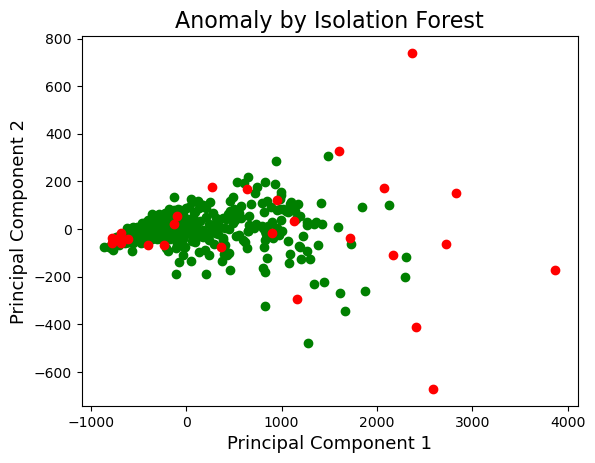

In [11]:
plot_anomaly(ir_outliers, 'Isolation Forest')

## One-class Support Vector Machines (SVMs)

In [12]:
from sklearn import svm 

model = svm.OneClassSVM(nu=0.05) 
model.fit(df) 
  
# Calculate the outlier scores for each point 
svm_scores = model.decision_function(df) 
  
# Identify the points with the highest outlier scores 
svm_outliers = np.argwhere(svm_scores < np.percentile(svm_scores, 15)) 


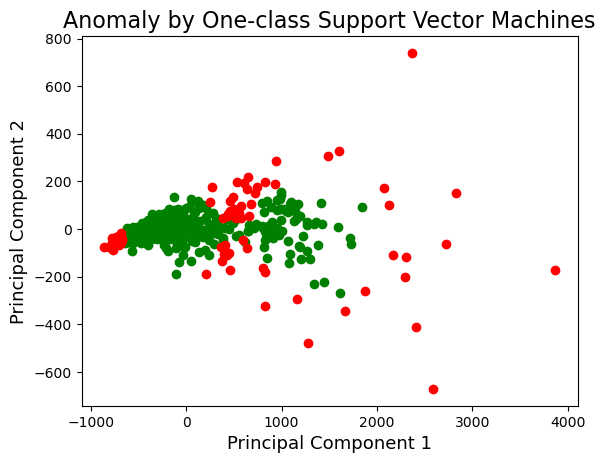

In [13]:
plot_anomaly(svm_outliers, "One-class Support Vector Machines")

# Common Outliers

In [14]:
common_outliers = np.intersect1d(svm_outliers, ir_outliers)
"""
out = [x for x in lof_outliers if x in ir_outliers or x in svm_outliers]
print(out)
out = [x for x in ir_outliers if x in lof_outliers or x in svm_outliers]
print(out)
out = [x for x in svm_outliers if x in ir_outliers or x in lof_outliers]
print(out)"""
print(common_outliers)

[  0  12  68  71  82 122 151 180 192 212 213 258 265 314 352 368 461 503
 504 505]


# Classification Models

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

def train_model(model, train, labels):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(train.values)

    model = model.fit(encoder.transform(train.values), labels)
    predict_fn = lambda x: model.predict(encoder.transform(x))
    return predict_fn

predict_fn = train_model(RandomForestClassifier(random_state=42), X_train, y_train)
print(predict_fn(X_test.values[:10]))

[1 1 1 1 1 1 1 1 1 1]


# Explainability Techniques

In [32]:
# Initialize an anchor explainer technique that use decision rules to explain specific decision taken by a classifier
from anchor import utils
from anchor import anchor_tabular

np.random.seed(1)
def generate_explanations(train, test, predict_fn, target_text):
    class_names = ["no-recurrence-events", "recurrence-events"]
    if "sklearn" in dataset:
        categorical_features = []
    else:
        categorical_features = list(range(0, test.shape[1]))
    categorical_names = {}
    temp_data = test.to_numpy()
    for feature in categorical_features:
        le = LabelEncoder()
        le.fit(temp_data[:, feature])
        temp_data[:, feature] = le.transform(temp_data[:, feature])
        categorical_names[feature] = le.classes_

    explainer = anchor_tabular.AnchorTabularExplainer(
        class_names,
        train.columns,
        train.to_numpy(),
        categorical_names
        )
    exp = explainer.explain_instance(target_text, predict_fn, threshold=0.95)
    print('Prediction: ', explainer.class_names[predict_fn(target_text.reshape(1, -1))[0]])
    print('Anchor: %s' % (' AND '.join(exp.names())))

In [33]:
generate_explanations(X_train, X_test, predict_fn, X_test.to_numpy()[0])

Prediction:  recurrence-events
Anchor: worst texture <= 27.38


# Explain Anomaly Detection

In [36]:
for i, common_outlier in enumerate(common_outliers):
    print("outlier", i)
    print(original_df.iloc[common_outlier].values.reshape(1, -1))
    generate_explanations(X_train, X_test, predict_fn, original_df.iloc[common_outlier].values.reshape(1, -1))
    print()

outlier 0
[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]]
Prediction:  recurrence-events
Anchor: mean fractal dimension > 0.06

outlier 1
[[1.917e+01 2.480e+01 1.324e+02 1.123e+03 9.740e-02 2.458e-01 2.065e-01
  1.118e-01 2.397e-01 7.800e-02 9.555e-01 3.568e+00 1.107e+01 1.162e+02
  3.139e-03 8.297e-02 8.890e-02 4.090e-02 4.484e-02 1.284e-02 2.096e+01
  2.994e+01 1.517e+02 1.332e+03 1.037e-01 3.903e-01 3.639e-01 1.767e-01
  3.176e-01 1.023e-01]]
Prediction:  recurrence-events
Anchor: worst smoothness <= 0.13

outlier 2
[[9.029e+00 1.733e+01 5.879e+01 2.505e+02 1.066e-01 1.413e-01 3.130e-01
  4.375e-02 2.111e-01 8.046e-02 3.274e-01 1.194e+00 1.885e+00 1.767e+01
  9.549e-03 8.606e-02 3.038e-01 3.322e-02 4.197e-02 9.559e-03 1.031

In [37]:
print(original_df.iloc[common_outliers].values)

[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [1.917e+01 2.480e+01 1.324e+02 1.123e+03 9.740e-02 2.458e-01 2.065e-01
  1.118e-01 2.397e-01 7.800e-02 9.555e-01 3.568e+00 1.107e+01 1.162e+02
  3.139e-03 8.297e-02 8.890e-02 4.090e-02 4.484e-02 1.284e-02 2.096e+01
  2.994e+01 1.517e+02 1.332e+03 1.037e-01 3.903e-01 3.639e-01 1.767e-01
  3.176e-01 1.023e-01]
 [9.029e+00 1.733e+01 5.879e+01 2.505e+02 1.066e-01 1.413e-01 3.130e-01
  4.375e-02 2.111e-01 8.046e-02 3.274e-01 1.194e+00 1.885e+00 1.767e+01
  9.549e-03 8.606e-02 3.038e-01 3.322e-02 4.197e-02 9.559e-03 1.031e+01
  2.265e+01 6.550e+01 3.247e+02 1.482e-01 4.365e-01 1.252e+00 1.750e-01
  4.228e-01 1.175e-01]
 [8.888e+00 1.464e+01 5.879e+01 2.440e+02 9.783e-02 1.531e-01 8.606